# ECE 580 Project Code: N-Gram Logistic Regression
## Fake News Detection using SVM and TF-IDF
- Rebecca Du (rrd17)
- Anish Parmar (avp30)

## Overview

In this notebook, we assess the performance of **Logistic Regression**. 

We employ the following setup:
- **Model**: Logistic Regression
- **Vectorizers**: TF-IDF (bigram, trigram, character n-gram, hybrid)
- **Stopwords**: Depends on vectorizer

# Imports

In [17]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion

In [18]:
#Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Anish
[nltk_data]     Parmar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1: Data Preprocessing

## Overview:

We are using the [ISOT Fake News Kaggle Dataset (2016-2017)](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset). It is a dataset formed by news articles various sources. 

It is composed of 2 CSV files:
- **'Fake.csv'**: 23,481 articles from various unreliable websites
- **'True.csv'**: 21,417 articles from Reuters.com

Each data point contains the following features:
- **Title**: title of the article
- **Text**: The full body of text in the article
- **Subject**: News, Politics, Other
- **Date**: Date of publication in 'Month Day, Year' format

## Step 1a: Load, Label, Combine Datasets

Since the Fake and True datasets are provided separately, we first **assign them labels and concatenate them into one dataframe**, which will be randomized and later used for training and testing our model. 

In [19]:
#Load datasets as dataframes
fake_df = pd.read_csv('Data/Fake.csv')
true_df = pd.read_csv('Data/True.csv')

In [20]:
#Check fake_df
fake_df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [21]:
#Check true_df
true_df

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [22]:
#Label fake_df values as '0', true_df values as '1'
fake_df['label'] = 0
true_df['label'] = 1

#Combine datasets into one
data = pd.concat([fake_df, true_df], ignore_index=True)

#Check data
data

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


## Step 1b: Combine Relevant Columns into 'Content'

Since we are mostly focused on the content of the articles, we will combine the title with the text columns and drop everything except the 'content' and 'label' columns

In [23]:
#Combine title and text into 'content' column
data['content'] = data['title'] + ' ' + data['text']

#Drop other columns (except for label)
data = data.drop(columns=['title', 'text', 'subject', 'date'])

#Check data
data

,label,content
0,0,Donald Trump Sends Out Embarrassing New Year’...
1,0,Drunk Bragging Trump Staffer Started Russian ...
2,0,Sheriff David Clarke Becomes An Internet Joke...
3,0,Trump Is So Obsessed He Even Has Obama’s Name...
4,0,Pope Francis Just Called Out Donald Trump Dur...
...,...,...
44893,1,'Fully committed' NATO backs new U.S. approach...
44894,1,LexisNexis withdrew two products from Chinese ...
44895,1,Minsk cultural hub becomes haven from authorit...
44896,1,Vatican upbeat on possibility of Pope Francis ...


In [24]:
preprocessed_data = data
with_stopwords_data = data

## Step 1c: Text Cleaning

Next, we will do some simple cleaning of the 'content' column:
- Convert it to lowercase
- Remove punctuation
- Remove stopwords

In [25]:
#Create a function for the data preprocessing tasks
def preprocessing(text):
    #Turn to lowercase
    text = text.lower()

    #Remove punctuation 
    text = re.sub(r'[^\w\s]', '', text)

    #Remove stopwords
    #Split text into individual words
    split_text = text.split()
    cleaned_text = []
    
    for word in split_text:
        if word not in stop_words:
            #Only keep non-stop word words
            cleaned_text.append(word)

    #Recombine into one string
    rejoined_text = ' '.join(cleaned_text)

    return rejoined_text

In [26]:
def preprocessing_no_stopwords_removal(text):
    # Turn to lowercase
    text = text.lower()

    # Remove punctuation (keeps only word characters and spaces)
    text = re.sub(r'[^\w\s]', '', text)

    # Optional: Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [27]:
#Apply preprocessing function to data
preprocessed_data['content'] = preprocessed_data['content'].apply(preprocessing)

#Check to make sure it looks right
preprocessed_data

,label,content
0,0,donald trump sends embarrassing new years eve ...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes internet joke thr...
3,0,trump obsessed even obamas name coded website ...
4,0,pope francis called donald trump christmas spe...
...,...,...
44893,1,fully committed nato backs new us approach afg...
44894,1,lexisnexis withdrew two products chinese marke...
44895,1,minsk cultural hub becomes authorities minsk r...
44896,1,vatican upbeat possibility pope francis visiti...


## Note about Stopwords:

Although stopwords are typically removed during unigram TF-IDF to focus on other important terms, they may offer some insight in regards to other n-gram TF-IDF formats, such as bigram and trigram. Thus, we create a dataset that retains the stopwords.

In [28]:
with_stopwords_data['content'] = with_stopwords_data['content'].apply(preprocessing_no_stopwords_removal)

with_stopwords_data

,label,content
0,0,donald trump sends embarrassing new years eve ...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes internet joke thr...
3,0,trump obsessed even obamas name coded website ...
4,0,pope francis called donald trump christmas spe...
...,...,...
44893,1,fully committed nato backs new us approach afg...
44894,1,lexisnexis withdrew two products chinese marke...
44895,1,minsk cultural hub becomes authorities minsk r...
44896,1,vatican upbeat possibility pope francis visiti...


## Step 1d: Train/Validation/Test Splitting

Now, we will split our cleaned data into training, validation, and testing sets. This will be useful for tuning hyperparameters and assessing model performance later on. 

The split we will choose is: 
- **Train**: 70%
- **Validation**: 15%
- **Test**: 15%

In [30]:
#Split into features (X) and labels (y)
X = preprocessed_data['content']
y = preprocessed_data['label']

In [31]:
# Split into train and temp 
train, temp_data = train_test_split(preprocessed_data, test_size=0.3, stratify=data['label'], random_state=42)

# Split temp into validation & test
val, test = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)

# Get features and labels for each split
X_train_prepoc, y_train_preproc = train['content'], train['label']
X_val_preproc, y_val_preproc = val['content'], val['label']
X_test_preproc, y_test_preproc = test['content'], test['label']

In [32]:
# Display the distribution of Fake and Real News in nonprocessed and processed datasets after splitting

print("Processed Data Train, Validation, & Test Distribution")
print("Train Labels:", y_train_preproc.value_counts(normalize=True))
print("Validation Labels:", y_val_preproc.value_counts(normalize=True))
print("Test Labels:", y_test_preproc.value_counts(normalize=True))

Processed Data Train, Validation, & Test Distribution
Train Labels: label
0    0.522973
1    0.477027
Name: proportion, dtype: float64
Validation Labels: label
0    0.52294
1    0.47706
Name: proportion, dtype: float64
Test Labels: label
0    0.523088
1    0.476912
Name: proportion, dtype: float64


In [50]:
#Split into features (X) and labels (y)
X = with_stopwords_data['content']
y = with_stopwords_data['label']

In [51]:
# Split into train and temp 
train, temp_data = train_test_split(with_stopwords_data, test_size=0.3, stratify=data['label'], random_state=42)

# Split temp into validation & test
val, test = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)

# Get features and labels for each split
X_train_stopword, y_train_stopword = train['content'], train['label']
X_val_stopword, y_val_stopword = val['content'], val['label']
X_test_stopword, y_test_stopword = test['content'], test['label']

In [52]:
# Display the distribution of Fake and Real News in nonprocessed and processed datasets after splitting

print("Processed Data Train, Validation, & Test Distribution")
print("Train Labels:", y_train_stopword.value_counts(normalize=True))
print("Validation Labels:", y_val_stopword.value_counts(normalize=True))
print("Test Labels:", y_test_stopword.value_counts(normalize=True))

Processed Data Train, Validation, & Test Distribution
Train Labels: label
0    0.522973
1    0.477027
Name: proportion, dtype: float64
Validation Labels: label
0    0.52294
1    0.47706
Name: proportion, dtype: float64
Test Labels: label
0    0.523088
1    0.476912
Name: proportion, dtype: float64


## Step 2: Trying Different N-Gram TF-IDF Vectorizers

**TF-IDF** is a combination of 2 terms:
- **Term Frequency (TF)**: how frequently a term appears in one given document ($d$), calculated as:
$$
\text{TF(term, document)} = \frac{\text{Number of times the term appears in the document}}{\text{Total number of terms in the document}}
$$

- **Inverse Document Frequency (IDF)**: how unique the term ($t$) is across all the documents ($d$), calculated as:
$$
\text{IDF(term, corpus)} = \log \left( \frac{\text{Total number of documents}}{\text{1 + Number of documents containing the term}} \right)
$$

In practice, TF-IDF is a weighting technique that **gives higher weight to**:
- **High TF score** (frequent in one document)
- and **Low IDF score** (not too common across all documents)

Here, we will experiment with different **N-Grams**, including:
- **Bigrams** (word pairs)
- **Trigrams** (word triplets)
- **Character-level N-Grams** (groups of frequently occurring characters, size 3-5)
- **Hybrid N-Gram** (a combination of word and character vectorizers)

**We will fit the vectorizer on the training data only** to avoid 'cheating' (aka allowing the model to learn from the data in the validation/testing sets, which would give it an unfair advantage in later testing). We will then transform all the splits.

## Step 2a: Initialize N-Gram Vectorizers

In [ ]:
# Trigram vectorizer WITHOUT stopwords
vectorizer_trigrams = TfidfVectorizer(
    ngram_range=(1, 3),      
    stop_words='english'
)

In [ ]:
# Trigram vectorizer WITH stopwords
vectorizer_trigrams_with_stopwords = TfidfVectorizer(
    ngram_range=(1, 3),      
    stop_words=None
)

In [ ]:
# Bigram vectorizer WITHOUT stopwords
vectorizer_bigrams = TfidfVectorizer(
    ngram_range=(1, 2),      
    stop_words='english'
)

In [58]:
# Character-level vectorizer
vectorizer_char_level_ngrams = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 5)
)

In [ ]:
# Word-level TF-IDF (unigrams and bigrams)
# unigrams and bigrams
# remove stopwords for word-level
word_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),      
    stop_words='english'     
)

# Character-level TF-IDF (trigrams to 5-grams)
# character n-grams within word boundaries
# char trigrams to 5-grams
# don't remove stopwords here
char_vectorizer = TfidfVectorizer(
    analyzer='char_wb',      
    ngram_range=(3, 5),      
    stop_words=None          
)

# combine both 
hybrid_vectorizer = FeatureUnion([
    ("word_tfidf", word_vectorizer),
    ("char_tfidf", char_vectorizer)
])

In [42]:
#Fit vectorizer on training data ONLY and transform
X_train_tfidf = vectorizer_bigrams.fit_transform(X_train_prepoc)

#Transform (NO FITTING TO AVOID CHEATING) validation, test sets
X_val_tfidf = vectorizer_bigrams.transform(X_val_preproc)
X_test_tfidf = vectorizer_bigrams.transform(X_test_preproc)

## Step 2b: Apply Vectorizers on Data and Assess Model

In [43]:
# Create function for calculating and printing precision, recall, f1 score, & confusion matrix 
# (only called for test set)
def model_evaluation(test, pred, name:string):
    precision = precision_score(test, pred)
    recall = recall_score(test, pred)
    f1 = f1_score(test, pred)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    print(f"\n{name} Classification Report:")
    print(classification_report(test, pred))

    cm = confusion_matrix(test, pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
    plt.xlabel(f'Predicted Labels ({name})')
    plt.ylabel('True Labels')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

### Bigram TF-IDF (No Stopwords)

Precision: 0.9824074074074074
Recall: 0.9909713574097135
F1 Score: 0.9866707997520149

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3523
           1       0.98      0.99      0.99      3212

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



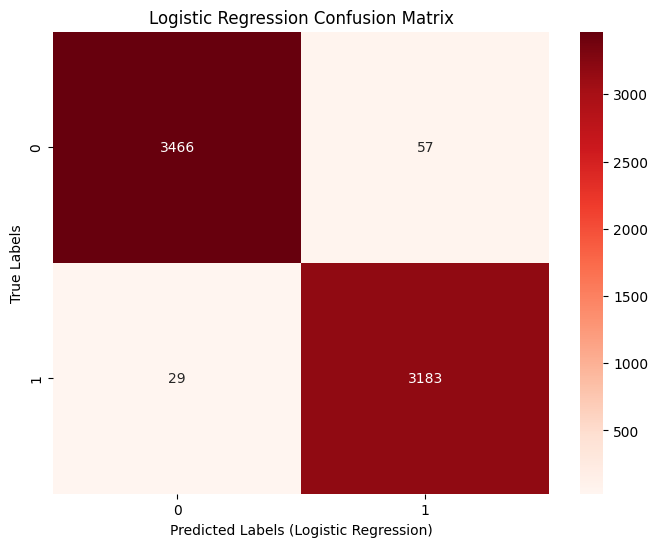

Logistic Regression (Bigram TF-IDF no stopwords) Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3522
           1       0.98      0.99      0.99      3213

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



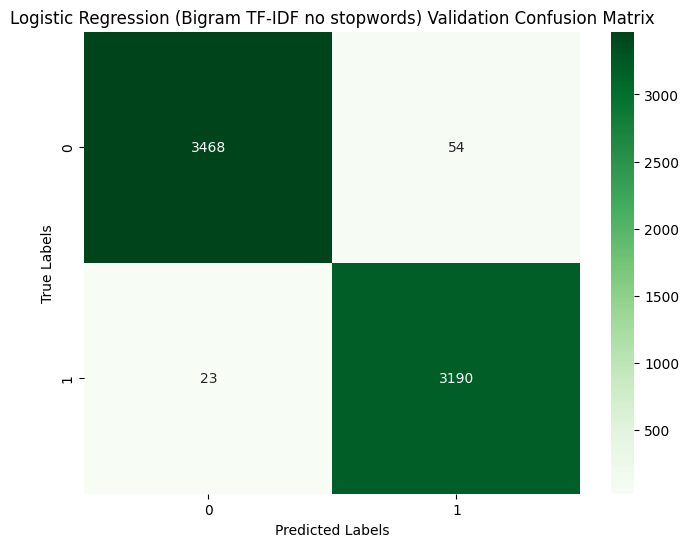

In [44]:
# Initialize & train Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)  
logistic_model.fit(X_train_tfidf, y_train_preproc)

# Make predictions on test set
lr_y_pred = logistic_model.predict(X_test_tfidf)

# Evaluate model
model_evaluation(y_test_preproc, lr_y_pred, "Logistic Regression")

# Validation set evaluation
y_val_pred = logistic_model.predict(X_val_tfidf)
print("Logistic Regression (Bigram TF-IDF no stopwords) Validation Classification Report:")
print(classification_report(y_val_preproc, y_val_pred))

cm_val = confusion_matrix(y_val_preproc, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression (Bigram TF-IDF no stopwords) Validation Confusion Matrix')
plt.show()

### Trigram TF-IDF (No Stopwords) 

In [46]:
#Fit vectorizer on training data ONLY and transform
X_train_tfidf = vectorizer_trigrams.fit_transform(X_train_prepoc)

#Transform (NO FITTING TO AVOID CHEATING) validation, test sets
X_val_tfidf = vectorizer_trigrams.transform(X_val_preproc)
X_test_tfidf = vectorizer_trigrams.transform(X_test_preproc)

Precision: 0.9791154791154791
Recall: 0.9925280199252802
F1 Score: 0.9857761286332715

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3523
           1       0.98      0.99      0.99      3212

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



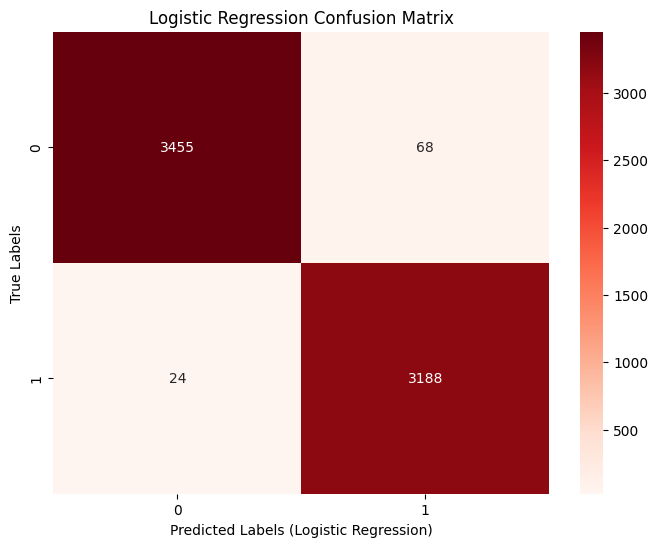

Logistic Regression (Trigram TF-IDF no stopwords) Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3522
           1       0.98      0.99      0.99      3213

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



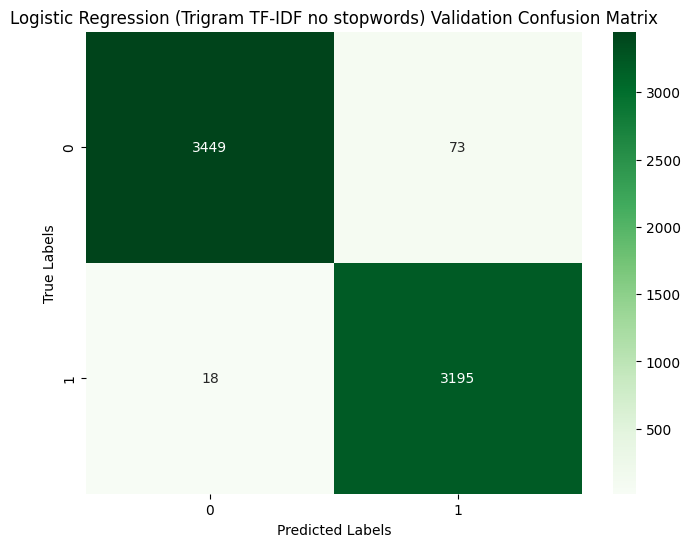

In [47]:
# Initialize & train Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)  
logistic_model.fit(X_train_tfidf, y_train_preproc)

# Make predictions on test set
lr_y_pred = logistic_model.predict(X_test_tfidf)

# Evaluate model
model_evaluation(y_test_preproc, lr_y_pred, "Logistic Regression")

# Validation set evaluation
y_val_pred = logistic_model.predict(X_val_tfidf)
print("Logistic Regression (Trigram TF-IDF no stopwords) Validation Classification Report:")
print(classification_report(y_val_preproc, y_val_pred))

cm_val = confusion_matrix(y_val_preproc, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression (Trigram TF-IDF no stopwords) Validation Confusion Matrix')
plt.show()

### Trigram TF-IDF (With Stopwords)

In [54]:
#Fit vectorizer on training data ONLY and transform
X_train_tfidf = vectorizer_trigrams_with_stopwords.fit_transform(X_train_stopword)

#Transform (NO FITTING TO AVOID CHEATING) validation, test sets
X_val_tfidf = vectorizer_trigrams_with_stopwords.transform(X_val_stopword)
X_test_tfidf = vectorizer_trigrams_with_stopwords.transform(X_test_stopword)

Precision: 0.9757891510879558
Recall: 0.9912826899128269
F1 Score: 0.9834749034749035

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3523
           1       0.98      0.99      0.98      3212

    accuracy                           0.98      6735
   macro avg       0.98      0.98      0.98      6735
weighted avg       0.98      0.98      0.98      6735



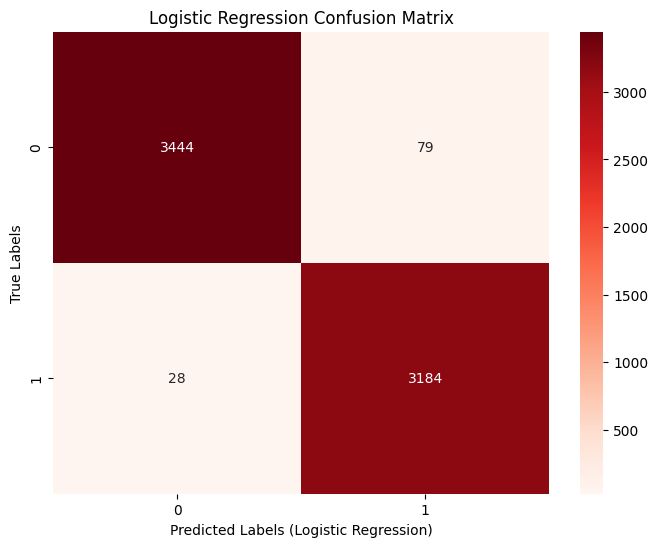

Logistic Regression (Trigram TF-IDF with stopwords) Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3522
           1       0.98      0.99      0.98      3213

    accuracy                           0.98      6735
   macro avg       0.98      0.98      0.98      6735
weighted avg       0.98      0.98      0.98      6735



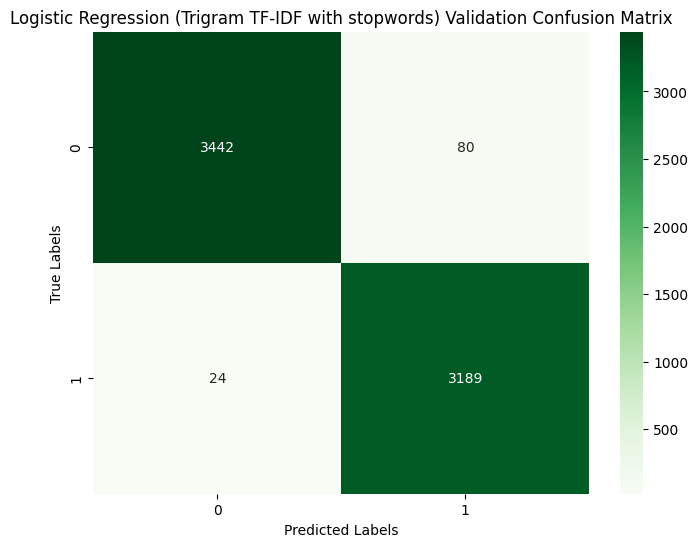

In [55]:
# Initialize & train Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)  
logistic_model.fit(X_train_tfidf, y_train_stopword)

# Make predictions on test set
lr_y_pred = logistic_model.predict(X_test_tfidf)

# Evaluate model
model_evaluation(y_test_stopword, lr_y_pred, "Logistic Regression")

# Validation set evaluation
y_val_pred = logistic_model.predict(X_val_tfidf)
print("Logistic Regression (Trigram TF-IDF with stopwords) Validation Classification Report:")
print(classification_report(y_val_stopword, y_val_pred))

cm_val = confusion_matrix(y_val_stopword, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression (Trigram TF-IDF with stopwords) Validation Confusion Matrix')
plt.show()

## Character-Level TF-IDF (With Stopwords)

In [59]:
#Fit vectorizer on training data ONLY and transform
X_train_tfidf = vectorizer_char_level_ngrams.fit_transform(X_train_stopword)

#Transform (NO FITTING TO AVOID CHEATING) validation, test sets
X_val_tfidf = vectorizer_char_level_ngrams.transform(X_val_stopword)
X_test_tfidf = vectorizer_char_level_ngrams.transform(X_test_stopword)

Precision: 0.9854489164086687
Recall: 0.9909713574097135
F1 Score: 0.9882024216081962

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3523
           1       0.99      0.99      0.99      3212

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



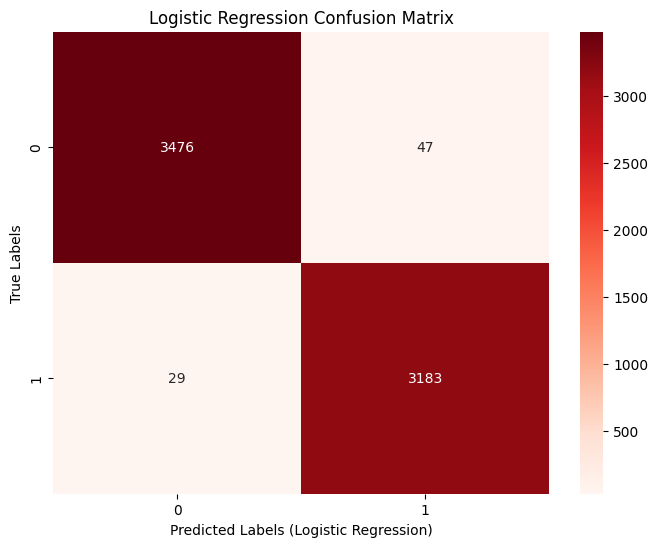

Logistic Regression (char_level_ngrams with stopwords) Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3522
           1       0.98      0.99      0.99      3213

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



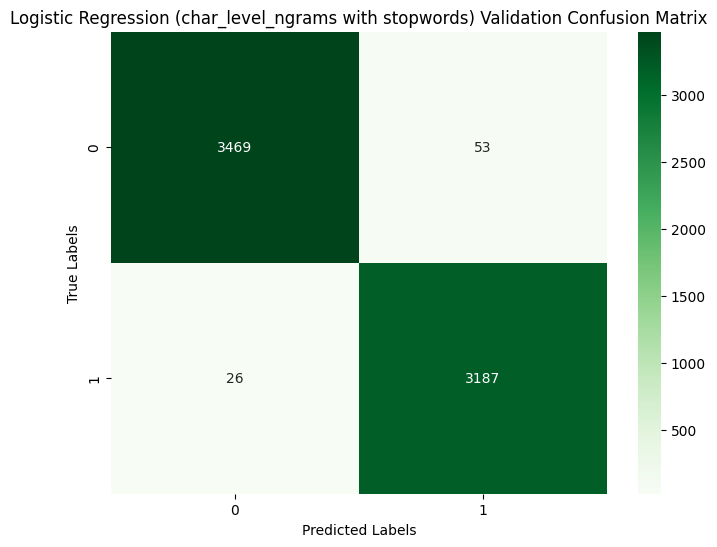

In [60]:
# Initialize & train Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)  
logistic_model.fit(X_train_tfidf, y_train_stopword)

# Make predictions on test set
lr_y_pred = logistic_model.predict(X_test_tfidf)

# Evaluate model
model_evaluation(y_test_stopword, lr_y_pred, "Logistic Regression")

# Validation set evaluation
y_val_pred = logistic_model.predict(X_val_tfidf)
print("Logistic Regression (char_level_ngrams with stopwords) Validation Classification Report:")
print(classification_report(y_val_stopword, y_val_pred))

cm_val = confusion_matrix(y_val_stopword, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression (char_level_ngrams with stopwords) Validation Confusion Matrix')
plt.show()

## Hybrid TF-IDF (Without Stopwords)

In [63]:
#Fit vectorizer on training data ONLY and transform
X_train_tfidf = hybrid_vectorizer.fit_transform(X_train_stopword)

#Transform (NO FITTING TO AVOID CHEATING) validation, test sets
X_val_tfidf = hybrid_vectorizer.transform(X_val_stopword)
X_test_tfidf = hybrid_vectorizer.transform(X_test_stopword)

Precision: 0.9870049504950495
Recall: 0.9931506849315068
F1 Score: 0.9900682805710739

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3523
           1       0.99      0.99      0.99      3212

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



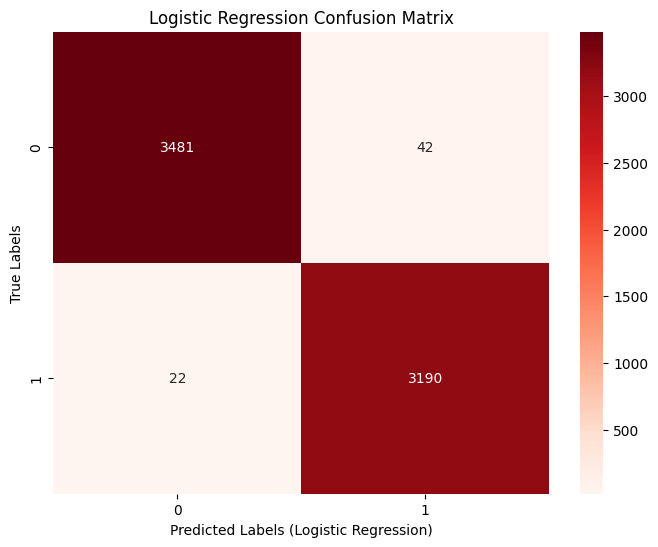

Logistic Regression (Hybrid Vectorizer) Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3522
           1       0.99      1.00      0.99      3213

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



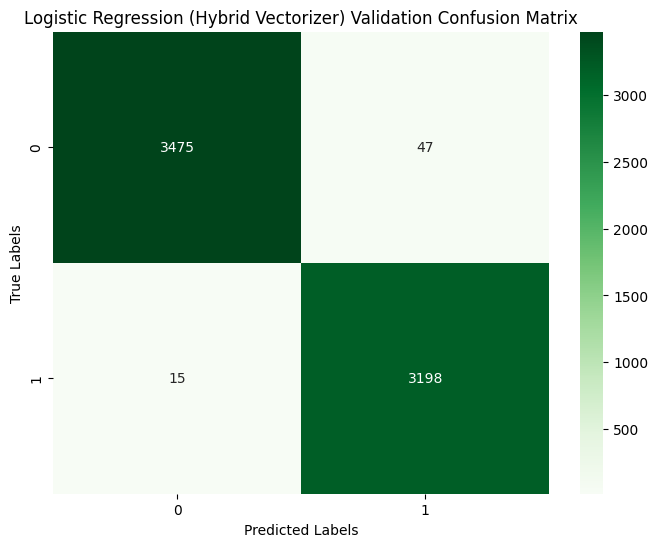

In [64]:
# Initialize & train Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)  
logistic_model.fit(X_train_tfidf, y_train_stopword)

# Make predictions on test set
lr_y_pred = logistic_model.predict(X_test_tfidf)

# Evaluate model
model_evaluation(y_test_stopword, lr_y_pred, "Logistic Regression")

# Validation set evaluation
y_val_pred = logistic_model.predict(X_val_tfidf)
print("Logistic Regression (Hybrid Vectorizer) Validation Classification Report:")
print(classification_report(y_val_stopword, y_val_pred))

cm_val = confusion_matrix(y_val_stopword, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression (Hybrid Vectorizer) Validation Confusion Matrix')
plt.show()